<h1>SI 670 Kaggle Competition 4</h1>

Team GSIs

In [398]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input 

In [115]:
tf.config.list_physical_devices('GPU')

[]

<h2>Load datasets</h2>

In [2]:
len(list(os.listdir("../data/images_train/bathroom"))), len(list(os.listdir("../data/images_train/kitchen")))

(301, 315)

In [348]:
data = tf.keras.utils.image_dataset_from_directory("../data/images_train", 
                                                   image_size = (256, 256), 
                                                   class_names = ['bathroom', 'kitchen'], 
                                                   shuffle = True,
                                                   batch_size = 32)

Found 616 files belonging to 2 classes.


In [349]:
X, y = zip(*data)

X = np.concatenate(X)
y = np.concatenate(y)

In [350]:
len(X), len(y)

(616, 616)

<h2>Preprocess Images</h2>

In [351]:
#flip labels so bathroom is 1
y = np.where(y == 1, 0, 1)

In [352]:
X = np.apply_along_axis(lambda s: s / 255.0, axis = 1, arr = X)

<h2>Split</h2>

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

<h2>Train Model</h2>

In [412]:
model = Sequential([
    # input
    tf.keras.layers.Conv2D(64, (3, 3), kernel_regularizer = l2(0.0001), input_shape = (256, 256, 3)), 
    tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5),  
    
    tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 

    
    tf.keras.layers.MaxPooling2D((3, 3)),
    tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 
    tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 

    
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = (256, 256, 3)), 
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64), 
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [413]:
loss = BinaryCrossentropy()
model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])

In [359]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 3, restore_best_weights = True)

model_history = model.fit(X_train, y_train, epochs = 50, batch_size = 8, 
                          #callbacks = [early_stopping], 
                          validation_data = (X_val, y_val))

Epoch 1/50
50/50 [==============================] - 273s 5s/step - loss: 0.6950 - accuracy: 0.5598 - val_loss: 0.7723 - val_accuracy: 0.4343
Epoch 2/50
50/50 [==============================] - 807s 16s/step - loss: 0.6894 - accuracy: 0.5903 - val_loss: 0.6309 - val_accuracy: 0.7879
Epoch 3/50
50/50 [==============================] - 1210s 25s/step - loss: 0.5244 - accuracy: 0.7684 - val_loss: 0.4368 - val_accuracy: 0.8182
Epoch 4/50
50/50 [==============================] - 288s 6s/step - loss: 0.4213 - accuracy: 0.8244 - val_loss: 0.3351 - val_accuracy: 0.8990
Epoch 5/50
50/50 [==============================] - 294s 6s/step - loss: 0.2687 - accuracy: 0.8830 - val_loss: 0.3626 - val_accuracy: 0.8384
Epoch 6/50
50/50 [==============================] - 278s 6s/step - loss: 0.2333 - accuracy: 0.9033 - val_loss: 0.2256 - val_accuracy: 0.9192
Epoch 7/50
50/50 [==============================] - 922s 19s/step - loss: 0.1696 - accuracy: 0.9313 - val_loss: 0.3040 - val_accuracy: 0.8788
Epoch 8/5

In [371]:
model.save("../saved_weights/haley_submit_3")

INFO:tensorflow:Assets written to: ../saved_weights/haley_submit_3/assets


INFO:tensorflow:Assets written to: ../saved_weights/haley_submit_3/assets


<h2>Resnet digression</h2>

In [417]:
resnet = tf.keras.applications.resnet.ResNet101(input_shape = (256, 256, 3), include_top = False, 
                                                classifier_activation = 'softmax')

In [426]:
x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)
predictions = tf.keras.layers.Dense(1, activation = 'softmax')(x)

model = Model(inputs = resnet.input, outputs = predictions)

In [ ]:
model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])

resnet_history = model.fit(X_train, y_train, validation_data = (X_val, y_val))

 5/13 [==========>...................] - ETA: 1:40 - loss: 1.9245 - accuracy: 0.4437

<h2>Test Model</h2>

In [360]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 26s 6s/step - loss: 0.3703 - accuracy: 0.8306


[0.3703078627586365, 0.8306451439857483]

In [361]:
model.evaluate(X_val, y_val)

4/4 [==============================] - 18s 4s/step - loss: 0.2256 - accuracy: 0.9192


[0.22562600672245026, 0.9191918969154358]

In [362]:
y_pred_prob = model.predict(X_test)

4/4 [==============================] - 25s 6s/step


In [363]:
y_pred_class = np.where(y_pred_prob > 0.5, 1, 0).flatten()

In [364]:
matrix = confusion_matrix(test_pred, y_test)

In [365]:
normalized_confusion_matrix = matrix / matrix.astype(float).sum(axis = 1)[:, np.newaxis]

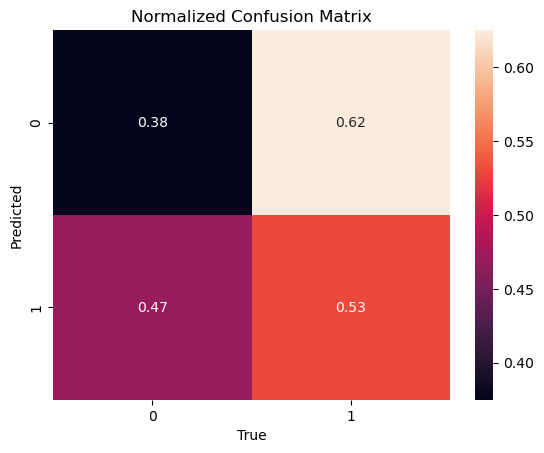

In [366]:
f = sns.heatmap(normalized_confusion_matrix, annot = True)
f.set(title = 'Normalized Confusion Matrix', xlabel = 'True', ylabel = 'Predicted')
plt.savefig("../plots/haley_heatmap_submission3.png")

<h2>Make Prediction</h2>

In [367]:
pred_data = tf.keras.utils.image_dataset_from_directory("../data/images_test", image_size = (256, 256), labels = None)
pred_data = pred_data.unbatch()
pred_images = [img / 255.0 for img in pred_data]

Found 149 files belonging to 1 classes.


In [386]:
imgs = []
ids = []

for f in os.listdir("../data/images_test"):
    img = tf.keras.utils.load_img(os.path.join("../data/images_test", f), target_size = (256, 256, 3))
    img = tf.keras.utils.img_to_array(img) / 255.0
    id = f.split(".")[0]
    ids.append(id)
    imgs.append(img)

In [388]:
predictions = model.predict(np.array(np.array(imgs)))

5/5 [==============================] - 28s 5s/step


<h2>Format predictions for submission</h2>

In [389]:
class_predictions = np.where(predictions > 0.5, 1, 0).flatten()

In [390]:
df = pd.DataFrame({'id': ids, 'class': class_predictions})

In [391]:
df.to_csv("../submissions/submit_3.csv", index = None)

In [392]:
df

,id,class
0,162,0
1,228,0
2,214,0
3,200,0
4,201,1
...,...,...
144,219,1
145,225,0
146,231,1
147,153,0
